Loading data and fitting model...
Historical range: 2020-10-31 to 2024-09-30
2020-10-31 -> estimated price: 10.1000
2020-12-15 -> estimated price: 10.6387
2024-09-30 -> estimated price: 11.8000
2024-10-30 -> estimated price: 12.1538
2025-03-29 -> estimated price: 13.0477
2025-09-30 -> estimated price: 12.3358


/tmp/ipython-input-862661030.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


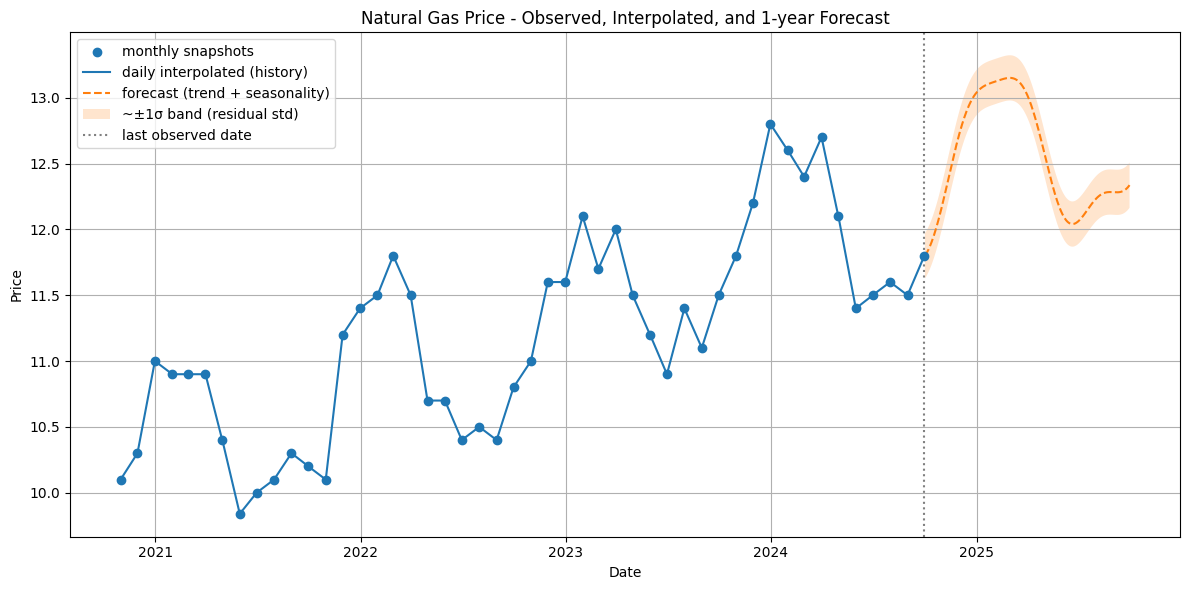

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from datetime import datetime, timedelta

FILENAME = "natural_gas_prices.csv"
DATE_COLS = ["date", "Date", "DATE"]
PRICE_COLS = ["price", "Price", "PRICE"]

#Data loading
def load_data(filename=FILENAME):
    df = pd.read_csv(filename)
    # find probable date & price columns
    date_col = next((c for c in df.columns if c in DATE_COLS), None)
    price_col = next((c for c in df.columns if c in PRICE_COLS), None)

    # if defaults not found, pick first two columns
    if date_col is None or price_col is None:
        if df.shape[1] >= 2:
            date_col = df.columns[0]
            price_col = df.columns[1]
        else:
            raise ValueError("CSV must have at least two columns (date and price).")

    df = df[[date_col, price_col]].rename(columns={date_col: "date", price_col: "price"})
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    # ensure month-end (user said data represents end-of-month snapshots).
    # If not exactly month-ends, that's OK — we still use them.
    return df

# Interpolation for historical dates
def build_interpolator(df):
    """
    Returns a daily-interpolated pandas Series covering the historical range.
    Uses linear time interpolation (robust and dependency-light).
    """
    s = pd.Series(df['price'].values, index=pd.DatetimeIndex(df['date']))
    # reindex to daily frequency between min and max
    daily_index = pd.date_range(start=s.index.min(), end=s.index.max(), freq='D')
    s_daily = s.reindex(daily_index)
    # interpolate with respect to time
    s_daily = s_daily.interpolate(method='time')
    return s_daily

# Simple forecasting
def fourier_features(dates, period=365.25, K=3):
    """
    Build Fourier sin/cos features for given dates (array-like of datetime64 or pd.DatetimeIndex).
    period: days of seasonality (annual=365.25)
    K: number of harmonics (controls complexity)
    Returns array shape (n_samples, 2*K)
    """
    if isinstance(dates, (pd.DatetimeIndex, pd.Series)):
        ts = np.array((dates - pd.Timestamp("1970-01-01")) / np.timedelta64(1, "D"))
    else:
        # assume list/array of datetimes
        ts = np.array([(pd.Timestamp(d) - pd.Timestamp("1970-01-01")) / np.timedelta64(1, "D") for d in dates])
    Xf = []
    for k in range(1, K+1):
        Xf.append(np.sin(2 * np.pi * k * ts / period))
        Xf.append(np.cos(2 * np.pi * k * ts / period))
    return np.vstack(Xf).T

def fit_forecast_model(df, K=3):
    """
    Fit a linear model: price ~ intercept + linear_trend(t) + Fourier seasonal terms
    t will be days since first observation.
    Returns fitted model and reference info.
    """
    dates = pd.to_datetime(df['date'])
    t0 = dates.min()
    t_days = (dates - t0).dt.days.values.reshape(-1, 1)  # linear trend
    X_fourier = fourier_features(dates, K=K)
    X = np.hstack([t_days, X_fourier])
    y = df['price'].values
    model = LinearRegression()
    model.fit(X, y)
    # compute residuals and std for a simple uncertainty band
    preds = model.predict(X)
    residuals = y - preds
    resid_std = np.std(residuals)
    return {
        'model': model,
        't0': t0,
        'K': K,
        'resid_std': resid_std,
        'period_days': 365.25
    }

def predict_price_from_model(fitinfo, predict_dates):
    """
    predict_dates: array-like of datetimes (or parseable strings)
    Returns numpy vector of predictions and simple +/-1 sigma bands.
    """
    dates = pd.to_datetime(predict_dates)
    t_days = (dates - fitinfo['t0']).days.values.reshape(-1,1)
    X_fourier = fourier_features(dates, period=fitinfo['period_days'], K=fitinfo['K'])
    X = np.hstack([t_days, X_fourier])
    preds = fitinfo['model'].predict(X)
    sigma = fitinfo['resid_std']
    return preds, preds - sigma, preds + sigma


# Putting it together
class GasPriceEstimator:
    def __init__(self, csv_filename=FILENAME):
        df = load_data(csv_filename)
        self.raw = df.copy()
        self.history_daily = build_interpolator(df)
        self.last_date = self.history_daily.index.max()
        self.first_date = self.history_daily.index.min()
        self.fitinfo = fit_forecast_model(df, K=3)  # 3 harmonics by default

    def estimate_price(self, date_input):
        """
        date_input: string 'YYYY-MM-DD' or datetime.date/datetime
        Returns float price estimate.
        Allowed dates:
          - any date between first_date and last_date (inclusive): uses daily interpolation
          - any date > last_date up to last_date + 365 days: uses forecast model
        Raises ValueError for dates beyond 1-year future.
        """
        date = pd.to_datetime(date_input).normalize()
        if date >= self.first_date and date <= self.last_date:
            # in-sample: use interpolated daily series
            return float(self.history_daily.loc[date])
        elif date > self.last_date:
            max_allowed = self.last_date + pd.Timedelta(days=365)
            if date > max_allowed:
                raise ValueError(f"Forecast allowed only up to 1 year after last historical date ({self.last_date.date()}). Requested: {date.date()}")
            preds, _, _ = predict_price_from_model(self.fitinfo, [date])
            return float(preds[0])
        else:
            # date before first historical point: we can extrapolate backwards using the model
            # (trend+season) -> allow backward upto reasonable limit (but user asked only past dates in range)
            preds, _, _ = predict_price_from_model(self.fitinfo, [date])
            return float(preds[0])

    def plot(self, forecast_days=365):
        """
        Plot raw monthly points, daily interpolation inside history,
        and forecast for `forecast_days` days after last_date.
        """
        plt.figure(figsize=(12,6))
        # raw monthly points
        plt.scatter(self.raw['date'], self.raw['price'], label='monthly snapshots', zorder=5)
        # daily interpolated history
        plt.plot(self.history_daily.index, self.history_daily.values, label='daily interpolated (history)')
        # forecast
        future_index = pd.date_range(start=self.last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')
        preds, low, high = predict_price_from_model(self.fitinfo, future_index)
        plt.plot(future_index, preds, linestyle='--', label='forecast (trend + seasonality)')
        plt.fill_between(future_index, low, high, alpha=0.2, label='~±1σ band (residual std)')
        plt.axvline(self.last_date, color='gray', linestyle=':', label='last observed date')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Natural Gas Price - Observed, Interpolated, and 1-year Forecast')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example / CLI-like demo

if __name__ == "__main__":
    # Load estimator
    print("Loading data and fitting model...")
    est = GasPriceEstimator(csv_filename=FILENAME)
    print(f"Historical range: {est.first_date.date()} to {est.last_date.date()}")
    # Example estimates:
    samples = [
        est.first_date,           # first day in dataset
        est.first_date + pd.Timedelta(days=45),  # an in-between date
        est.last_date,            # last historical date
        est.last_date + pd.Timedelta(days=30),   # 1 month into forecast
        est.last_date + pd.Timedelta(days=180),  # 6 months into forecast
        est.last_date + pd.Timedelta(days=365)   # 1 year into forecast (limit)
    ]
    for d in samples:
        price = est.estimate_price(d)
        print(f"{pd.to_datetime(d).date()} -> estimated price: {price:.4f}")

    # Plot
    est.plot(forecast_days=365)
